<a href="https://colab.research.google.com/github/UMMEATHIYA/Simple_CNN_Model-UNet_Model-/blob/master/CSC578_UMMEATHIYA_HW05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5: Convolutional Neural Networks

The goal of this assignment is to deepen your understanding of Convolutional Neural Networks (CNNs) by building and training one from scratch using only Python and NumPy. You will:
1. Implement the convolutional forward and backward propagation operations.
2. Construct a simple CNN with two convolutional layers followed by a fully connected (FC) layer.
3. Implement the gradient descent optimization step (copyed from HW3).
4. Train the network on a small subset of the MNIST dataset.

Assingment outlines:
- CNN [60/60]
- UNet [40/40]


Let's first import necessary libraries
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
tools for data mining and data analysis.
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.

In [57]:
import numpy as np
import torch
import matplotlib.pyplot as plt

np.random.seed(1) # for reproductivity

# 1- Convolutional Layer Implementation

## 1.1 - Forward propogation

In a Convolutional Neural Network (CNN), the forward propagation for a convolutional layer can be expressed as follows:
$$
\begin{align}
Z^{\ell} =& A^{\ell-1} \ast F^{\ell} + b^{\ell}\\
A^{\ell} =& \phi(Z^{\ell}),
\end{align}
$$
where
- $A^{\ell-1}\in \mathbb{R}^{n\times n}$ represents the input feature map from the previous layer (or the input image in the case of the first layer),
- $F\in \mathbb{R}^{f\times f}$ is the filter (or kernel) used for this layer, which slides over the input feature map,
- $b\in \mathbb{R}$ is the bias term added uniformly to each position in $Z^{\ell}$,
- $\ast$ denotes the convolution operation, which involves sliding the filter over the input and computing element-wise multiplications and sums,
- $\phi$ represents the activation function (such as ReLU) applied element-wise to the output  $Z^{\ell}$  to obtain the activated feature map  $A^{\ell}$.

**Note**: For simplicity in this programming assignment, we assume that the input feature map has **one channel** and only **one filter** is utilized in each convolution layer.

### Padding [3/3]
To implement forward propagation in a convolutional neural network, it is often necessary to apply padding to the input data. The `zero_pad()` function allows us to add a border of zeros around the input feature map, effectively increasing its dimensions. This process helps to control the spatial size of the output, ensuring that the feature map dimensions remain consistent or are adjusted as needed for subsequent layers.

**Exercise 1 [3/3]**: Implement the zero_pad() function, which takes a batch of examples A and a padding parameter p, then adds zeros around all four edges of each example. For guidance on how to add padding to arrays, you may refer to the official NumPy documentation on [np.pad()](https://numpy.org/doc/stable/reference/generated/numpy.pad.html).

In [58]:
import numpy as np
def zero_pad(A, pad):
    ### Your Code Here
    A_padded = np.pad(A, ((0, 0), (pad, pad), (pad, pad)), mode='constant', constant_values=0)
    return A_padded

In [59]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1) # for reproducibility
n = 3
batch_size = 10
X = np.random.randn(batch_size, n, n)
print(f"Original Image X[1]:\n{X[1]}")

# Define padding size
pad = 1

# Apply zero padding
X_padded = zero_pad(X, pad)
print(f"Padded Image X_padded[1]:\n{X_padded[1]}")

Original Image X[1]:
[[-0.24937038  1.46210794 -2.06014071]
 [-0.3224172  -0.38405435  1.13376944]
 [-1.09989127 -0.17242821 -0.87785842]]
Padded Image X_padded[1]:
[[ 0.          0.          0.          0.          0.        ]
 [ 0.         -0.24937038  1.46210794 -2.06014071  0.        ]
 [ 0.         -0.3224172  -0.38405435  1.13376944  0.        ]
 [ 0.         -1.09989127 -0.17242821 -0.87785842  0.        ]
 [ 0.          0.          0.          0.          0.        ]]


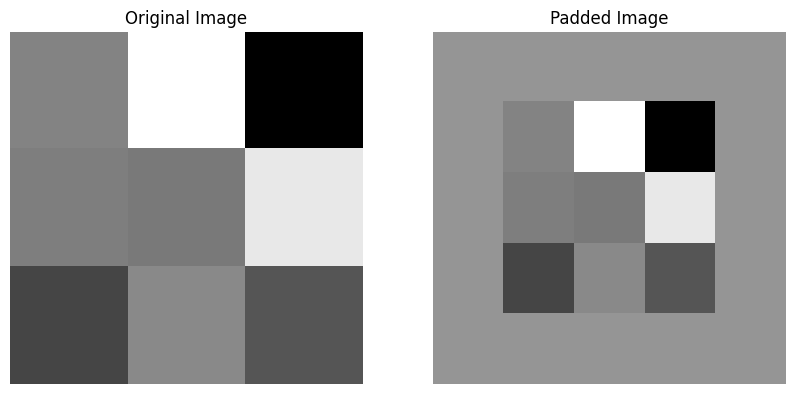

In [60]:
# Plot the original image and the padded image side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Original image plot on the left
ax1.imshow(X[1], cmap='gray')
ax1.set_title("Original Image")
ax1.axis('off')

# Padded image plot on the right
ax2.imshow(X_padded[1], cmap='gray')
ax2.set_title("Padded Image")
ax2.axis('off')

# Show the plot
plt.show()

### One Step Convolution [3/3]

In this part, you will implement a single step of convolution. This will be used to build a convolutional unit. Let $A_p$ be denoted the padded input whose dimension becomes $(n+2p)\times (n+2p)$. In this step, you will apply a **locally linear transformation** by performaing an element-wise multiplication between a given `filter` and a selected `region` from the padded input image. Then, sum the products and add a `bias` term to obtain the final value value. This operation will yield the transformed value for a single pixel in the output feature map.

**Exercise 2 [3/3]**: Implement the `one_step_conv()` function. This function should take a region from the padded input, a filter, and a bias term as inputs, and it should return the result of the convolution operation for that specific region. You may find [np.sum()](https://numpy.org/doc/stable/reference/generated/numpy.sum.html) useful for this implementation.

In [61]:
def one_step_conv(region, filter, bias):
    result = np.sum(region * filter) + bias
    return result.item()

In [62]:
i = j = 0
filter_size = 3
filter = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
bias = 0
A_padded = X_padded[1]
region = A_padded[i:i+filter_size, j:j+filter_size] # extract a local region
print(f"region=\n{region}")
output = one_step_conv(region, filter, bias)
print(f"Output of one_step_conv: {output}")

region=
[[ 0.          0.          0.        ]
 [ 0.         -0.24937038  1.46210794]
 [ 0.         -0.3224172  -0.38405435]]
Output of one_step_conv: -1.0780535823765585


### Stride [4/4]

When using a specified `stride`, the output feature map  $Z \in \mathbb{R}^{m \times m}$  is computed by sliding the filter  $F$  across the padded input  $A_p$ . The output dimension `m` is determined by the formula:

$$
m = \left\lfloor \frac{n + 2p - f}{s} + 1 \right\rfloor
$$

Each entry $Z_{ij}$ in the output feature map represents the result of a single step convolution, where the appropriate region of the padded input is extracted and transformed by the filter. The extraction of this local region is guided by the `stride`, which determines the steps taken between successive filter applications across  $A_p$.

For each position  $(i, j)$  in  Z , the top-left corner of the region in the padded input can be calculated as follows:

$$
i_\text{start} = i \times \text{stride}, \quad j_\text{start} = j \times \text{stride}
$$


The region should be extracted are:

$$
A_p[i_\text{start} : i_\text{start} + f -1, j_\text{start} : j_\text{start} + f-1]
$$


**Exercise 3 [4/4]**: Implement the get_region() function, which extracts and returns the appropriate region from the padded input  `A_padded`  based on the current  `(i,j)`, `stride`, and `filter_size`. You may find [numpy array Indexing](https://numpy.org/doc/stable/user/basics.indexing.html) useful.

In [63]:
def get_region(A_padded, i, j, stride, filter_size):
    ### Your Code Here
    i_start = i * stride
    j_start = j * stride
    region = A_padded[i_start : i_start + filter_size, j_start : j_start + filter_size]
    return region

In [8]:
i = j = 0
stride = 2
get_region(A_padded, i, j, stride, filter_size)

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        , -0.24937038,  1.46210794],
       [ 0.        , -0.3224172 , -0.38405435]])

### Forward Pass [10/10]

The `conv_forward()` function performs the forward propagation for a convolutional layer, where a `filter` is applied across the input to produce an output feature map. This process involves several key steps, including *padding*, *convolution*, and *activation*. The `conv_forward()` takes a batch of input samples `A_prev` (either from the previous convolutional layer or the initial input), `filter`, `bias`, activaiton function `act`, and hyperparameters including `stride` and `pad`.

The forward pass for each convolution layer can be broken down as follows:
- Padding: If specified, zero-padding is applied to each sample in the batch using `zero_pad()` to maintain or adjust spatial dimensions.
- Convolution: For each position in the output feature map, `conv_forward()` extracts a region from the padded input using `get_region() and applies `one_step_conv()` with the filter and bias. This operation is repeated for all positions, and across all examples in the batch.
- Activation: Once the convolution operation produces the output `Z`, the activation function (ReLU, in this case) is applied to introduce non-linearity, resulting in the activated output `A`.

**Exercise 4 [10/10]**: Implement the `conv_forward()` function. Assume using `ReLU()`, which you may recall from Homework 2. The function should return both `A` (the activated output feature map) and a `cache` containing `A_prev` and `Z`, which will be essential for backpropagation.

In [64]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, x):
        return np.maximum(0, x)

    def derivative(self, x):
        return np.where(x >= 0, 1, 0)

    def __call__(self, x):
        return self.forward(x)

In [65]:
def conv_forward(A_prev, filter, bias, stride=1, pad=0, act=ReLU()):
    # A_prev.shape = (batch_size, n, n)
    # A.shape = (batch_size, m, m)

    batch_size = A_prev.shape[0]
    n = A_prev.shape[1] # input size
    f = filter.shape[0] # filter size
    m = (n + 2 * pad - f) // stride + 1 # output size
    Z = np.zeros((batch_size, m, m)) # output

    # Padding
    ### Your Code Here
    A_prev_pad = zero_pad(A_prev, pad)

    #Convolution
    for b in range(batch_size):
        for i in range(m):
            for j in range(m):
              ### Your Code Here
                region = get_region(A_prev_pad[b], i, j, stride, f)
                Z[b, i, j] = one_step_conv(region, filter, bias)
    # Activation and cache
    A = act(Z)
    cache = (A_prev, Z)
    return A, cache

In [66]:
act = ReLU()
A, cache = conv_forward(X, filter, bias, stride, pad, act)
print(f'A[1]={A[1]}')

A[1]=[[0.         1.07805358]
 [0.55648256 0.        ]]


## 1.2 - Backward() [15/15]

Let $E$ to denote the cost. Given $dA^{\ell}$, which is the gradient of $E$ with respect to  $A^{\ell}$, we can compute $dZ^{\ell}$ as follows:
$$
dZ^{\ell} = \phi^{\prime}(Z^{\ell}) \odot dA^{\ell}
$$
Recall $Z^{\ell} = A^{\ell-1}\ast F^{\ell} + b^{\ell}$. In the convolution operation, the input image $A^{\ell-1}$ is divided into a sequence of small local regions (or **blocks**) $A^{\ell-1}_{ij}\in \mathbb{R}^{f\times f}$, where $i,j\in [m]$, and each element of $Z^{\ell}$ can be expressed as:
$$
Z_{ij}^{\ell} = \langle A_{ij}^{\ell-1}, F^{\ell} \rangle + b
$$
where $\langle X, Y\rangle$ represents the elementwise dot product of matrices $X$ and $Y$:

$$
\langle X, Y\rangle = \sum_{i,j} X_{ij} Y_{ij}
$$

Using the chain rule, we can derive the following partial derivatives:

$$
\begin{align}
&\frac{\partial Z^{\ell}_{ij}}{\partial F^{\ell}} = A_{ij}^{\ell-1}\\
&\frac{\partial Z^{\ell}_{ij}}{\partial b} =1\\
&\frac{\partial Z^{\ell}_{ij}}{\partial A_{ij}^{\ell-1}} = F^{\ell}
\end{align}
$$

We can then compute the gradients for  $dF^{\ell}$  and  $db^{\ell}$  by summing over all positions  $(i, j)$ :

$$
\begin{align}
&dF^{\ell} = \sum_{i,j=1}^{m} \frac{\partial Z^{\ell}_{ij}}{\partial F^{\ell}} \cdot \frac{\partial E}{\partial Z^{\ell}_{ij}}
= \sum_{i,j=1}^{m} A_{ij}^{\ell-1} \cdot d Z^{\ell}_{ij}\\
&db^{\ell} = \sum_{i,j=1}^{m} \frac{\partial Z^{\ell}_{ij}}{\partial b} \cdot \frac{\partial E}{\partial Z^{\ell}_{ij}}
=\sum_{i,j=1}^{m} d Z^{\ell}_{ij}
\end{align}
$$


Calculating  $dA^{\ell-1}$ is more complex because each pixel in  $A^{\ell-1}$ may influence multiple positions in  $Z^{(\ell)}$. We can, however, accumulate gradients for each **block** $A^{\ell-1}_{ij}\in \mathbb{R}^{f\times f}$ as follows:

$$
\begin{align}
dA^{\ell-1} &= 0\\
dA^{\ell-1}_{ij} &= dA^{\ell-1}_{ij} + \frac{\partial Z_{ij}^{\ell}}{\partial A_{ij}^{\ell-1}} \cdot \frac{\partial E}{\partial Z^{\ell}_{ij}}\\
&=dA^{\ell}_{ij} + F^{\ell} \cdot dZ^{\ell}_{ij},\quad \forall i,j\in [m].
\end{align}
$$

**Exercise 5 [15/15]**: Implement `conv_backward()`. This function will calculate $dA^{\ell-1}$,  $dF^{\ell}$, and $db^{\ell}$ using the steps outlined above. Remember that $dA^{\ell-1}$ must be accumulated over all regions that contributed to each element in the output.

In [67]:
def conv_backward(dA, filter, bias, cache, act=ReLU(), stride=1, pad=0):
    # dA.shape = (batch_size, m, m)
    # dF.shape = (f, f)
    # db.shape = (1,1)
    # dA_prev = (batch_size, n, n)

    A_prev, Z = cache
    batch_size = A_prev.shape[0]
    n = A_prev.shape[1]
    f = filter.shape[0]
    m = (n + 2 * pad - f) // stride + 1

    dF = np.zeros_like(filter, dtype=np.float64)
    db = np.zeros_like(bias, dtype=np.float64)
    dA_prev = np.zeros_like(A_prev, dtype=np.float64)

    # Apply padding to A_prev if needed
    if pad > 0:
        A_prev_padded = zero_pad(A_prev, pad)
        dA_prev_padded = zero_pad(A_prev, pad)
    else:
        A_prev_padded = A_prev
        dA_prev_padded = dA_prev

    # Compute the gradient dZ, dF, db, dA_prev_padded
    dZ = act.derivative(Z) * dA
    for b in range(batch_size):
        for i in range(m):
            for j in range(m):
                ### Your Code Here
                region = get_region(A_prev_padded[b], i, j, stride, f)
                dF += dZ[b, i, j] * region  # Accumulate dF
                db += dZ[b, i, j]  # Accumulate db
                i_start = i * stride
                j_start = j * stride
                dA_prev_padded[b, i_start:i_start + f, j_start:j_start + f] += dZ[b, i, j] * filter
    # Remove padding from dA_prev if added
    if pad > 0:
        dA_prev = dA_prev_padded[pad:-pad, pad:-pad]
    else:
        dA_prev = dA_prev_padded

    return dA_prev, dF, db

In [68]:
# Define the upstream gradient dA
dA = np.random.randn(*A.shape)

# Compute the backward pass
dA_prev, dF, db = conv_backward(dA, filter, bias, cache, act, stride, pad)

# Print results for verification
print("dA[1] (Upstream gradient):\n", dA[1])
print("dA_prev[1] (Gradient wrt A_prev):\n", dA_prev[1])
print("dF (Gradient wrt filter):\n", dF)
print("db (Gradient wrt bias):\n", db)

dA[1] (Upstream gradient):
 [[ 0.42349435  0.07734007]
 [-0.34385368  0.04359686]]
dA_prev[1] (Gradient wrt A_prev):
 [[ 0.          0.04221375  1.28084725 -1.10061918 -0.69803203]
 [ 0.          1.14472371  2.82413046  0.50249434 -1.92253974]
 [ 0.          0.90085595  0.54077985 -0.12289023 -1.2245077 ]]
dF (Gradient wrt filter):
 [[-1.37033461  0.34640552  1.08872162]
 [ 1.30614291 -1.78087485 -0.28059913]
 [ 0.8219175   1.8084983  -0.16008673]]
db (Gradient wrt bias):
 1.8615718689004241


## 1.3 - Simple CNN

In this part of the assignment, you will construct a basic Convolutional Neural Network (CNN) with **three layers**:

1. Two Convolutional Layers: These layers will extract spatial features from the input images. Each convolutional layer consists of a filter that slides over the input to detect patterns. The output from these layers will be feature maps that capture localized information in the image, such as edges, textures, or more complex patterns.
2. One Fully Connected (FC) Layer: After the convolutional layers, the extracted features are flattened into a single vector and fed into a fully connected layer. This layer serves as the final stage of the network, where it combines the learned features to make predictions or classifications.

CNN Structure:

1. Layer 1 - Convolutional Layer:
-	The first layer takes the input image and applies a convolution operation using a set of filters. The output of this layer is a set of feature maps that highlight various features of the image.
- Typically, an activation function like ReLU follows the convolution operation to introduce non-linearity, which enables the network to learn complex patterns.
2. Layer 2 - Convolutional Layer:
- The second layer performs another convolution on the feature maps produced by the first layer. This layer can capture higher-level features by combining the information from the initial features.
- Again, ReLU is applied to add non-linearity to the output.
3. Layer 3 - Fully Connected (FC) Layer:
- The final layer is a fully connected layer, which takes the flattened output of the second convolutional layer as input. The FC layer combines all the extracted features and generates the final output.
- This layer usually outputs probabilities for each class in a classification task, enabling the model to make predictions.

### Flattening [5/5]

To connect the convolutional layers with the fully connected layer, you will need to implement a `flatten()` function. This function will take the output from the convolutional layer and reshape it into a single long vector.

**Exercise 6 [1/1]**: Implement the `flatten()` method to reshape the output from the convolutional layer into a one-dimensional vector. This step is essential for transitioning from the convolutional structure to the fully connected layers in your CNN. You may find the [reshape()](https://numpy.org/doc/2.0/reference/generated/numpy.reshape.html) function helpful for this implementation.


In [69]:
def flatten(A):
    # A.shape = (batch_size, m, m)
    # A_flattened.shape = (batch_size, m**2)
    batch_size = A.shape[0]
    m = A.shape[1]
    ### Your Code Here
    A_flattened = A.reshape(batch_size, -1)
    return A_flattened

In [70]:
np.random.seed(1) # for reproductivity
A = np.random.randn(batch_size, 5, 5)
a = flatten(A)
print(a.shape)
print(a[0])

(10, 25)
[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071
 -0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842
  0.04221375  0.58281521 -1.10061918  1.14472371  0.90159072  0.50249434
  0.90085595]


### Fully Connected Layer [5/5]

The fully connected (FC) layer in a CNN acts as the final stage where the learned features from the convolutional layers are combined to make predictions. In an FC layer, each input neuron is connected to every output neuron, allowing the network to integrate all extracted features to classify or make decisions based on the input data.

For this assignment, the implementation of the fully connected layer is similar to the one in Homework 3, with a minor change: the data shape is now structured as `(batch_size, input_dim)`, rather than `(input_dim, batch_size)`. This change aligns the fully connected layer with the input shape produced by the convolutional layers, ensuring compatibility throughout the network.

**Exercise [5/5]**: Implement the `FCN()`

In [71]:
def FCN(A_prev, W, b, act=ReLU()):
    # A_prev.shape = (batch_size, n_x)
    # W.shape = (n_h, n_x)
    # b.shape = (n_h, 1)
    # A.shape = (batch_size, n_y)
    Z =  np.dot(A_prev, W.T)+ b.T
    A = act(Z)
    cache = (A_prev, Z)
    return A, cache

def FCN_backward(dA, W, b, cache, act=ReLU()):
    A_prev, Z = cache
    ### Your Code Here
    dZ = act.derivative(Z) * dA
    dW = np.dot(dZ.T, A_prev) / A_prev.shape[0]
    db = np.sum(dZ, axis=0, keepdims=0)
    dA_prev = np.dot(dZ, W)
    return dA_prev, dW, db

### Implementation of a Simple CNN [15/15]

It’s time to implement a simple Convolutional Neural Network (CNN) composed of three layers: two convolutional layers followed by a fully connected (FC) layer. This basic architecture will allow the network to extract and combine features from input images, enabling it to make predictions based on the learned patterns.


The network architecture follows this structure:

`Conv1 -> Conv2 -> FCN`

Layer Configurations:

1. Conv1: The first convolutional layer
- Filter Size: 3x3,
- Padding: 1,
- Stride: 1,
2. Conv2: The second convolutional layer
- Filter Size: 3x3,
- Padding: 0,
- Stride: 2,
3. FCN: This layer takes the output from the second convolutional layer, flattens it, and fully connects it to the output layer.

**Exercise 7 [15/15]**: Implement `SimpleCNN()`.

In [72]:
class SimpleCNN:
    def __init__(self, n_x, n_y, act=ReLU()):
        self.n_x = n_x  # Input dimensions (n_x, n_x)
        self.n_y = n_y  # Number of classes
        self.act = act
        self.init_params()

    def init_params(self):
        # Initialize parameters
        self.hparams = {}
        self.params = {}

        # Define hyperparameters directly in a dictionary
        f1, p1, s1 = 3, 1, 1  # Filter size, padding, stride for first conv layer
        f2, p2, s2 = 3, 0, 2  # Filter size, padding, stride for second conv layer

        self.hparams['f1'], self.hparams['p1'], self.hparams['s1'] = f1, p1, s1
        self.hparams['f2'], self.hparams['p2'], self.hparams['s2'] = f2, p2, s2

        # Initialize the first conv layer
        W1 = np.random.randn(f1, f1) / f1
        b1 = np.zeros((1,))

        # Initialize the second conv layer
        W2 = np.random.randn(f2, f2) / f2
        b2 = np.zeros((1,))

        # Initialize the fully connected layer
        self.n_h = self._calculate_flattened_size()
        W3 = np.random.randn(self.n_y, self.n_h) / np.sqrt(self.n_h)
        b3 = np.zeros((self.n_y, 1))

        self.params['W1'], self.params['b1'] = W1, b1
        self.params['W2'], self.params['b2'] = W2, b2
        self.params['W3'], self.params['b3'] = W3, b3

    def forward(self, X):
        # Extract hyper-parameters
        f1, p1, s1 = self.hparams['f1'], self.hparams['p1'], self.hparams['s1']
        f2, p2, s2 = self.hparams['f2'], self.hparams['p2'], self.hparams['s2']

        # Extract parameters
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3']

        # Initialize caches
        self.caches = {}

        # Forward pass through the first conv layer
        ### Your Code Here
        A1, cache1 = conv_forward(X, W1, b1, stride=s1, pad=p1, act=self.act)
        ### Your Code Here

        # Forward pass through the second conv layer
        ### Your Code Here
        A2, cache2 = conv_forward(A1, W2, b2, stride=s2, pad=p2, act=self.act)
        A2_flattened = flatten(A2)
        ### Your Code Here

        # Forward pass through the FCN
        ### Your Code Here
        A3, cache3 = FCN(A2_flattened, W3, b3, act=self.act)
        ### Your Code Here

        self.caches['cache1'] = cache1
        self.caches['cache2'] = cache2
        self.caches['cache3'] = cache3

        return A3

    def backward(self, dA3):
        self.grads = {}
        # Backward pass through the FC
        W3, b3 = self.params['W3'], self.params['b3']
        cache3 = self.caches['cache3']
        ### Your Code Here
        dA2_flattened, dW3, db3 = FCN_backward(dA3, W3, b3, cache3, act=self.act)

        ### Your Code Here
        self.grads['dW3'] = dW3
        self.grads['db3'] = db3

        # Backward pass through the second conv layer
        W2, b2 = self.params['W2'], self.params['b2']
        cache2 = self.caches['cache2']
        f2, p2, s2 = self.hparams['f2'], self.hparams['p2'], self.hparams['s2']

        dA2 = dA2_flattened.reshape(self.caches['cache2'][1].shape)
        dA1, dW2, db2 = conv_backward(dA2, W2, b2, cache2, act=self.act, stride=s2, pad=p2)


        self.grads['dW2'] = dW2
        self.grads['db2'] = db2

        # Backward pass through the first conv layer
        W1, b1 = self.params['W1'], self.params['b1']

        cache1 = self.caches['cache1']
        f1, p1, s1 = self.hparams['f1'], self.hparams['p1'], self.hparams['s1']
        ### Your Code Here
        dA1 = dA1.reshape(self.caches['cache1'][1].shape)
        dA0, dW1, db1 = conv_backward(dA1, W1, b1, cache1, act=self.act, stride=s1, pad=p1)

        self.grads['dW1'] = dW1
        self.grads['db1'] = db1


    def get_params(self):
        return self.params

    def get_grads(self):
        return self.grads

    def get_hparams(self):
        return self.hparams
    def get_caches(self):
        return self.caches

    def _calculate_flattened_size(self):
        f1, p1, s1 = self.hparams['f1'], self.hparams['p1'], self.hparams['s1']
        f2, p2, s2 = self.hparams['f2'], self.hparams['p2'], self.hparams['s2']
        output_size = (self.n_x - f1 + 2 * p1) // s1 + 1
        output_size = (output_size - f2 + 2 * p2) // s2 + 1
        return output_size ** 2


In [73]:
np.random.seed(1)
# Initialize the network
n_x = 8
n_y = 3
batch_size = 10
X = np.random.randn(batch_size, n_x, n_x)
cnn = SimpleCNN(n_x, n_y, act=ReLU())

# Forward pass
output = cnn.forward(X)
print("output.shape", output.shape)
print("Forward pass output:", output[1])

# Backward pass
dA3 = np.random.randn(batch_size, n_y)
cnn.backward(dA3)
print("Gradients after backward pass:")
for param, grad in cnn.grads.items():
    print(f"{param}: {grad}")

output.shape (10, 3)
Forward pass output: [0.         0.         1.04883126]
Gradients after backward pass:
dW3: [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.0191127   0.03103019  0.13389767  0.08059534  0.0956052   0.05739537
   0.14862555 -0.02159048  0.14028111]
 [ 0.06213789 -0.15700678 -0.00938486 -0.22491393 -0.57497419 -0.12600851
  -0.17237473  0.1036705  -0.19165249]]
db3: [ 0.          0.78404729 -2.01924914]
dW2: [[ 0.06451301  1.60394279  2.71211503]
 [-2.88799817 -0.39415962 -1.83482646]
 [ 0.92806237  0.2894827  -2.26416198]]
db2: [-1.56235633]
dW1: [[ 2.47023871 -1.76019073  2.3784198 ]
 [-1.3494006  -3.8039922  -2.80329844]
 [-0.53510231  1.18740885 -3.52608645]]
db1: [-0.91026697]


## 1.4 - Gradient Descent to Train SimpleCNN

To train your SimpleCNN, you will implement the gradient descent algorithm. Gradient descent is an optimization technique used to minimize the loss function by iteratively updating the model parameters (weights and biases). In the context of neural networks, gradient descent adjusts the parameters in the direction that reduces the cost, ultimately improving the model’s performance.

The following code for implementing one step of **gradient descent** and computing the cost using **squared loss** is adapted from Homework 3.

In [76]:
def gradient_descent_step(params, grads, learning_rate):
    for key in params.keys():
        gkey = 'd' + key
        # Reshape the gradient to match the bias shape if necessary
        if params[key].ndim != grads[gkey].ndim:
            grads[gkey] = grads[gkey].reshape(params[key].shape)
        params[key] -= learning_rate * grads[gkey]

def compute_cost(A, Y):
    m = Y.shape[0]
    cost = np.sum((A - Y) ** 2) / (2 * m)
    return cost

Iteration 0, Loss: 5.571886534557877
Iteration 1, Loss: 5.054169583001987
Iteration 2, Loss: 4.890788663506741
Iteration 3, Loss: 4.8372773010261145
Iteration 4, Loss: 4.800298196816598
Iteration 5, Loss: 4.772554886524179
Iteration 6, Loss: 4.7433696581862375
Iteration 7, Loss: 4.714201298654519
Iteration 8, Loss: 4.68675768718658
Iteration 9, Loss: 4.6614548587644595


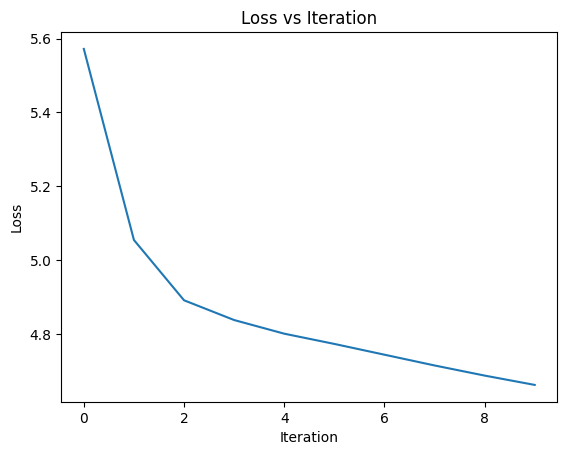

In [77]:
np.random.seed(1)
n_x = 32
n_y = 10
batch_size = 10
X = np.random.randn(batch_size, n_x, n_x)
Y = np.random.randn(batch_size, n_y)

cnn = SimpleCNN(n_x, n_y, act=ReLU())
learning_rate = 0.01
loss = []
for i in range(10):
    output = cnn.forward(X) # forward pass
    loss.append(compute_cost(output, Y)) # loss compute
    dA3 = (output - Y) / batch_size # gradient at the output
    cnn.backward(dA3) # backward pass
    gradient_descent_step(cnn.get_params(), cnn.get_grads(), learning_rate) # gradient descent update
    print(f"Iteration {i}, Loss: {loss[-1]}")

plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs Iteration')
plt.show()

### Use Simple CNN for Image Classificaiton on MNIST

In this section, you will train your SimpleCNN to classify handwritten digits from the MNIST dataset. The MNIST dataset consists of 28x28 pixel grayscale images of handwritten digits (0–9).

Due to the computational intensity of convolution operations, particularly with the nested for-loops in the implementation, training can be quite slow. To make the training process more manageable, we will select only 100 samples from each class in the dataset. This will provide a representative sample while allowing the training process to complete in a reasonable amount of time.

By the end of this exercise, you should have a functional CNN that can classify MNIST digits with a small dataset, giving you practical experience with CNNs and their applications in image classification.


In [78]:
import tensorflow as tf
import numpy as np

# Load and normalize MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

classes_to_include = [0, 1, 2]
num_samples_per_class = 100     # Number of samples per class for training

# Filter the training and test sets for the specified classes
train_filter = np.isin(y_train, classes_to_include)
test_filter = np.isin(y_test, classes_to_include)

X_train, y_train = X_train[train_filter], y_train[train_filter]
X_test, y_test = X_test[test_filter], y_test[test_filter]

# Function to randomly select a specified number of samples per class from the training data
def select_random_samples(X, y, classes, num_samples):
    selected_X, selected_y = [], []
    for label in classes:
        indices = np.where(y == label)[0]
        selected_indices = np.random.choice(indices, num_samples, replace=False)
        selected_X.append(X[selected_indices])
        selected_y.append(y[selected_indices])
    return np.concatenate(selected_X), np.concatenate(selected_y)

# Select the specified number of samples per class for the training set
X_train, y_train = select_random_samples(X_train, y_train, classes_to_include, num_samples_per_class)
X_test, y_test = select_random_samples(X_test, y_test, classes_to_include, num_samples_per_class)

# Check the shapes to verify
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training data shape: (300, 28, 28)
Training labels shape: (300,)
Testing data shape: (300, 28, 28)
Testing labels shape: (300,)


In [79]:
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y]

In [80]:
np.random.seed(1) # for reproductivity
n_x = 28  # 28 x 28 images in MNIST
n_y = len(classes_to_include)  # 3 classes

# Initialize model
cnn = SimpleCNN(n_x, n_y, act=ReLU())
learning_rate = 0.01

# One-hot encode the labels
y_train = one_hot_encode(y_train, n_y)
y_test = one_hot_encode(y_test, n_y)

# Initialize lists for tracking loss
train_loss = []
test_loss = []

# Training loop
for i in range(50):
    # Testing phase
    output = cnn.forward(X_test)  # Forward pass
    test_loss.append(compute_cost(output, y_test))  # Compute loss

    # Training phase
    output = cnn.forward(X_train)  # Forward pass
    train_loss.append(compute_cost(output, y_train))  # Compute loss
    dA3 = (output - y_train) / len(X_train)  # Gradient at output layer
    cnn.backward(dA3)  # Backward pass
    gradient_descent_step(cnn.get_params(), cnn.get_grads(), learning_rate)  # Update parameters

    if i % 10 == 0:
        print(f"Iteration {i}, Train Loss: {train_loss[-1]}, Test Loss: {test_loss[-1]}")

Iteration 0, Train Loss: 0.4898658450030681, Test Loss: 0.4909915579443834
Iteration 10, Train Loss: 0.4534920841901883, Test Loss: 0.4545258102229708
Iteration 20, Train Loss: 0.42013601041580223, Test Loss: 0.42133962269998987
Iteration 30, Train Loss: 0.39899389071415486, Test Loss: 0.4001379423308907
Iteration 40, Train Loss: 0.3862471534182913, Test Loss: 0.3868786563817627


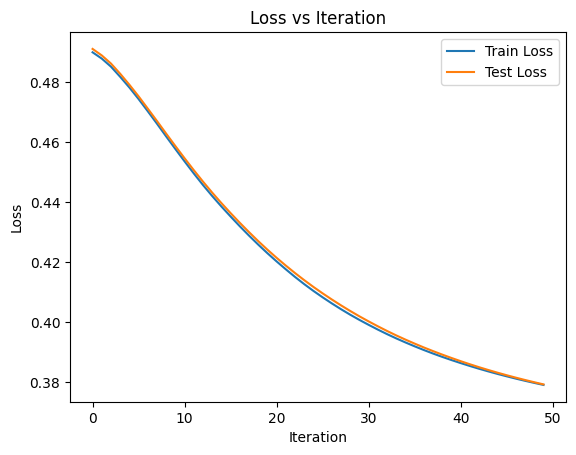

In [81]:
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs Iteration')
plt.legend()
plt.show()

# 2 - Semantic Image

In this section, you will implement a U-Net model that is commonly used for semantic segmentation tasks. U-Net follows an encoder-decoder architecture with skip connections, allowing detailed localization while retaining deep contextual information.

## 2.1 - UNet model [40/40]

The first step is to implement the `conv_block()` method. This method will be used in both the encoder (downsampling path) and the decoder (upsampling path), so it is essential to get it right.

The `conv_block()` consists of two consecutive convolutional layers, each followed by a `ReLU` activation function. You will use `Conv2d` layers with a filter size of `3`, and to **maintain** the input-output size, hence, you will add `padding=1` to the convolutions.

**Note**: We could define a class `ConvBlock` that contains these two convolutional layers, but PyTorch offers a more concise way to stack layers using `nn.Sequential()`. This allows us to quickly implement a shallow neural network by sequentially applying weight layers and activations.

**Exercise 4 [5/5]**: Implement the `conv_block()` method using `nn.Sequential()`.

In [82]:
from torch import nn

def conv_block(in_channels, out_channels):
    return nn.Sequential(
        ### Your Code Here
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU()
    )

In [83]:
# Test for conv_block
torch.manual_seed(1)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

in_channels = 3
out_channels = 64
input_tensor = torch.randn(1, in_channels, 256, 256)

conv_block_instance = conv_block(in_channels, out_channels)

# Pass the input tensor through the conv_block
output_tensor = conv_block_instance(input_tensor)

# Print the output shape
print("Output shape:", output_tensor.shape)
print(f"otuput: {output_tensor[:, 0, :, :]}")

Using device: cuda
Output shape: torch.Size([1, 64, 256, 256])
otuput: tensor([[[0.0000, 0.1997, 0.0000,  ..., 0.2494, 0.4599, 0.2160],
         [0.0000, 0.2631, 0.0000,  ..., 0.0996, 0.0000, 0.1223],
         [0.0006, 0.2564, 0.3777,  ..., 0.3040, 0.2214, 0.0000],
         ...,
         [0.1491, 0.0268, 0.0120,  ..., 0.0000, 0.1029, 0.0000],
         [0.1466, 0.0000, 0.2036,  ..., 0.0000, 0.0421, 0.2388],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
       grad_fn=<SliceBackward0>)


Next, we will use the `conv_block()` method as a fundamental building block to implement the U-Net architecture. As illustrated in Figure 1 from [U-Net: Convolutional Networks for Biomedical
Image Segmentation](https://arxiv.org/pdf/1505.04597), the U-Net has three main components: **encoder** (downsampling path), **bottleneck**, and **decoder** (upsampling path):

- Encoder (Downsampling):
  - The encoder consists of **four** convolutional blocks (conv_block()) followed by *max-pooling* layers.
  - Each `conv_block()` *maintain* the spatial dimensions and increases the number of filters.
  - The number of filters (or channels) used in each `conv_block()` is defined by the input argument `features`.
  - We will use `nn.ModuleList()` to store the ConvNets generated by `conv_block()` so that each layer is part of the model and facility the usage of GPUs.
- Bottleneck:
  - The bottleneck is a `conv_block()` that operates at the deepest layer in the U-Net, with the largest number of filters and the smallest spatial dimensions.
- Decoder (Upsampling):
  - The `decoder` consists of **four** 2x2 upconvolutions, which will be implemented using `nn.ConvTranspose2d()`, which are included in `nn.ModuleList()`
  - After upsampling, the feature map is concatenated with the corresponding feature map `embedding` from the `encoder` path (via skip connections).
  - To concatenate correctly, both the upsampled activation `x` and the encoder feature map `embedding` must have the same spatial dimensions. If not, the `embedding` from the encoder is **center-cropped** using the `center_crop()` method to match the size of the upsampled activation.
  - After concatenation, the result is passed through another convolutional block (conv_block()) to refine the features.
- Output Layer:
  - The output is obtained by passing the activaiton `x` to a 1x1 conv.

*Note*:
- In the original paper, each `conv_block()` reduces the spatial dimensions as they don't use padding. However, to adpat to our dataset, we maintain the spatial dimensions using `padding=1` in `conv_block()`
- The stride in UNet is specified in Figure 1 of the [U-Net paper](https://arxiv.org/pdf/1505.04597).
- The origial UNet does not use padding. However, we use `padding=1` in `conv_block` to facility our dataset.

**Exercise 5 [35/35]**: Implement the class `UNet`.

In [93]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        # Encoder (Downsampling)
        self.encoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        for feature in features:
            ### Your Code Here
            self.encoder.append(self._conv_block(in_channels, feature))  # Conv block
            in_channels = feature
            ### Your Code Here

        # Bottleneck
        ### Your Code Here
        self.bottleneck = conv_block(features[-1], features[-1] * 2)
        ### Your Code Here

        # Decoder (Upsampling)
        self.decoder = nn.ModuleList()
        self.upconvs = nn.ModuleList()
        for feature in reversed(features):
            ### Your Code Here
            self.decoder.append(conv_block(feature * 2, feature))
            self.upconvs.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            ### Your Code Here

        # Final Convolution (1x1 Convolution)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        encodings = []
        for layer in self.encoder:
            ### Your Code Here
            x = layer(x)
            encodings.append(x)
            x = self.pool(x)
            ### Your Code Here

        # Bottleneck
        ### Your Code Here
        x = self.bottleneck(x)
        ### Your Code Here

        # Decoder with upsampling and skip connections
        encodings = encodings[::-1]
        for encoding, norm_conv, upconv in zip(encodings, self.decoder, self.upconvs):
            x = upconv(x)
            if x.shape != encoding.shape:
                encoding = self.center_crop(encoding, x.shape[2], x.shape[3])
            ### Your Code Here
            x = torch.cat([encoding, x], dim=1)
            x = norm_conv(x)
            ### Your Code Here

        return self.final_conv(x)

    def _conv_block(self, in_channels, out_channels):
        return conv_block(in_channels, out_channels)

    def center_crop(self, encoding, target_height, target_width):
        _, _, h, w = encoding.size()
        diff_y = (h - target_height) // 2
        diff_x = (w - target_width) // 2
        return encoding[:, :, diff_y:(diff_y + target_height), diff_x:(diff_x + target_width)]

In [94]:
# Example usage
torch.manual_seed(1)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
model = UNet(in_channels=3, out_channels=1).to(device)
print(model)

Using device: cuda
UNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

## 2.2 - Load Dataset

We will testify our customized `UNet` on Oxford-IIIT Pet Dataset for sematic segmentation. The Oxford-IIIT Pet Dataset contains images of 37 pet breeds, annotated with pixel-level labels for semantic segmentation. Each image includes a corresponding segmentation mask, where each pixel is labeled as part of the pet or the background, making it ideal for training and evaluating segmentation models.

In [95]:
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, random_split
import torch
import numpy as np
from torchvision.transforms import functional as F

# Custom mask transformation to keep integer values
class ToIntMask:
    def __call__(self, mask):
        mask = F.pil_to_tensor(mask).long()  # Convert PIL image to tensor
        return mask.squeeze(0) - 1  # Convert the mask to 0, 1, 2


# Define the transformations for the images
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Define the transformation for the masks (no normalization, keep as integers)
mask_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    ToIntMask()
])

# Load the Oxford-IIIT Pet Dataset with segmentation masks
train_dataset = OxfordIIITPet(root='./data', split='trainval', target_types='segmentation',
                        transform=image_transform, target_transform=mask_transform, download=True)
test_dataset = OxfordIIITPet(root='./data', split='test', target_types='segmentation',
                        transform=image_transform, target_transform=mask_transform, download=True)

# Create DataLoaders for train and test
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Check shapes of a batch of data from train and test sets
train_images, train_masks = next(iter(train_loader))
test_images, test_masks = next(iter(test_loader))

print(f"Train images shape: {train_images.shape}, Train masks shape: {train_masks.shape}")
print(f"Test images shape: {test_images.shape}, Test masks shape: {test_masks.shape}")

Train images shape: torch.Size([128, 3, 128, 128]), Train masks shape: torch.Size([128, 128, 128])
Test images shape: torch.Size([128, 3, 128, 128]), Test masks shape: torch.Size([128, 128, 128])


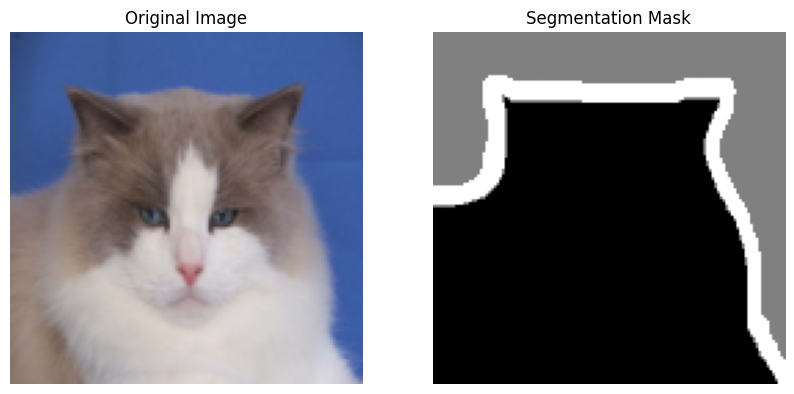

In [97]:
import torchvision.transforms.functional as F

torch.manual_seed(1)

idx = 0  # Index of the image to visualize
# Convert the tensor image to a PIL image
image_pil = F.to_pil_image(train_images[idx])  # Convert the tensor to a PIL image for visualization

# Display the first image and its mask from the batch
plt.figure(figsize=(10, 5))

# Show the original image
plt.subplot(1, 2, 1)
plt.imshow(image_pil)
plt.title("Original Image")
plt.axis('off')

# Show the corresponding mask
plt.subplot(1, 2, 2)
plt.imshow(train_masks[idx].squeeze(), cmap="gray")  # Display the mask in grayscale
plt.title("Segmentation Mask")
plt.axis('off')

plt.show()

## 2.3 - Train and Predict

In [109]:
def train(model, optimizer, criterion, train_loader, device, num_epochs=50, scheduler=None):
    losses = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}")
        if scheduler is not None:
            scheduler.step()

    return losses

In [110]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

torch.manual_seed(1)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
model = UNet(in_channels=3, out_channels=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)  # Reduce LR by factor of 2 (gamma=0.5) every epoch

# Training loop
print("Training...")
train_losses = train(model, optimizer, criterion, train_loader, device, num_epochs=50)

Using device: cuda
Training...
Epoch [1/50], Loss: 0.9309090601986852
Epoch [2/50], Loss: 0.8757254912935454
Epoch [3/50], Loss: 0.7984321384594358
Epoch [4/50], Loss: 0.7219028329027111
Epoch [5/50], Loss: 0.6921602939737255
Epoch [6/50], Loss: 0.6623617040699926
Epoch [7/50], Loss: 0.6488633423015989
Epoch [8/50], Loss: 0.6396502770226578
Epoch [9/50], Loss: 0.6312526916635448
Epoch [10/50], Loss: 0.6190293821795233
Epoch [11/50], Loss: 0.604471665004204
Epoch [12/50], Loss: 0.5805856010009502
Epoch [13/50], Loss: 0.5612187940498878
Epoch [14/50], Loss: 0.5361328751876436
Epoch [15/50], Loss: 0.50521385464175
Epoch [16/50], Loss: 0.48352443760839003
Epoch [17/50], Loss: 0.46318824846169043
Epoch [18/50], Loss: 0.4416088328279298
Epoch [19/50], Loss: 0.49904982077664345
Epoch [20/50], Loss: 0.43205985837969285
Epoch [21/50], Loss: 0.40743033433782644
Epoch [22/50], Loss: 0.39611026028106955
Epoch [23/50], Loss: 0.38263616274143086
Epoch [24/50], Loss: 0.3742586939499296
Epoch [25/50],

In [111]:
def plot_predictions_grid(images, masks, predicted_masks, num_samples=9):
    """
    Plot a grid of images, ground truth masks, and predicted masks.

    Args:
        images (Tensor): Input images, shape (batch_size, channels, height, width).
        masks (Tensor): Ground truth masks, shape (batch_size, 1, height, width).
        predicted_masks (Tensor): Predicted masks from the model, shape (batch_size, height, width).
        num_samples (int): Number of samples to plot in the grid (default is 9).
    """
    # Plot the num_samples in a grid (num_samples x 3)
    fig, axes = plt.subplots(num_samples, 3, figsize=(9, 3 * num_samples))  # Fix width, adjust height for clarity

    # Loop over the first num_samples images and masks
    for idx in range(num_samples):
        image = images[idx].cpu().permute(1, 2, 0).numpy()  # Convert to HWC for visualization
        mask = masks[idx].cpu().numpy().squeeze()  # Convert mask to a 2D array
        predicted = predicted_masks[idx].cpu().numpy().squeeze()  # Convert predicted mask to a 2D array

        # Original Image
        axes[idx, 0].imshow(image)
        axes[idx, 0].axis('off')
        axes[idx, 0].set_title("Original Image")

        # Ground Truth Mask
        axes[idx, 1].imshow(mask, cmap='gray')
        axes[idx, 1].axis('off')
        axes[idx, 1].set_title("Ground Truth Mask")

        # Predicted Mask
        axes[idx, 2].imshow(predicted, cmap='gray')
        axes[idx, 2].axis('off')
        axes[idx, 2].set_title("Predicted Mask")

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

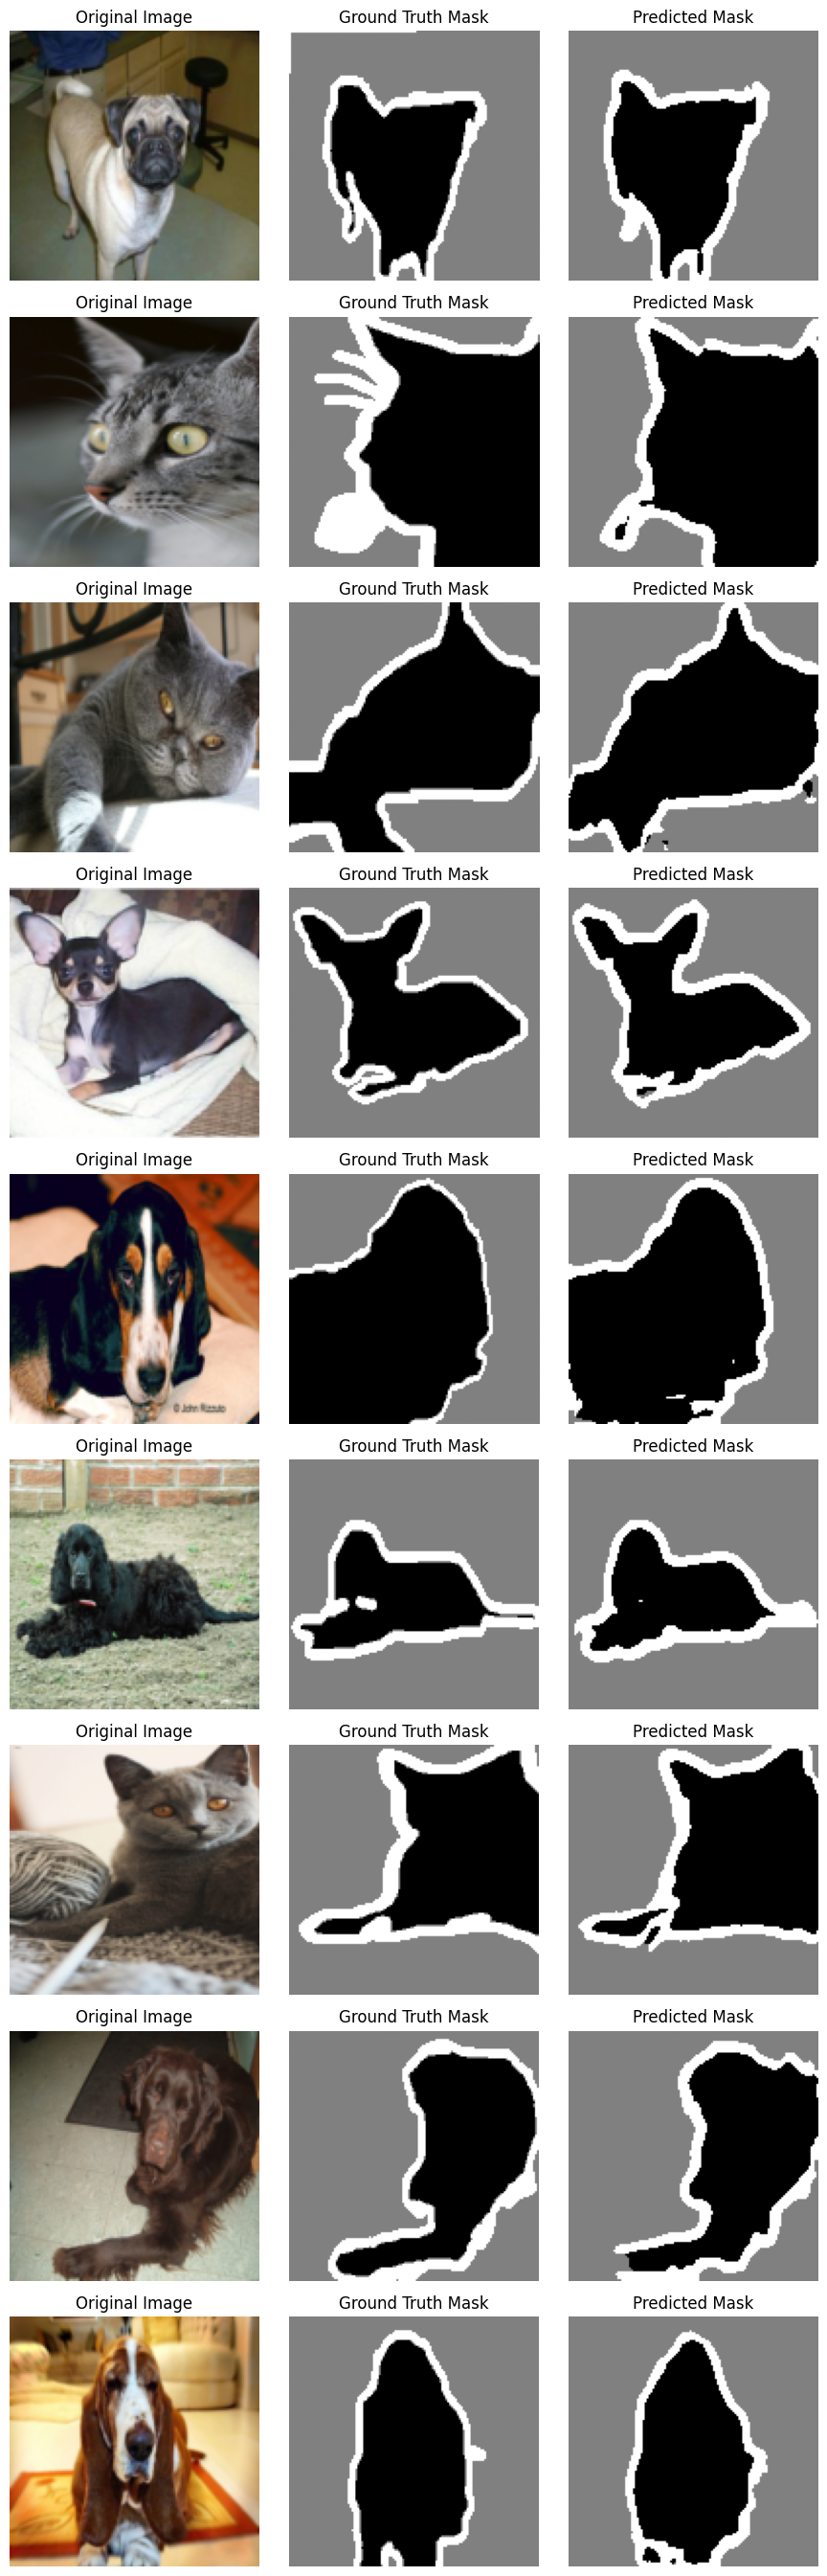

In [112]:
# Test on train set
model.eval()
images, masks = next(iter(train_loader))
images = images.to(device)
with torch.no_grad():
    predictions = model(images)
predicted_masks = torch.argmax(predictions, dim=1)
plot_predictions_grid(images, masks, predicted_masks)

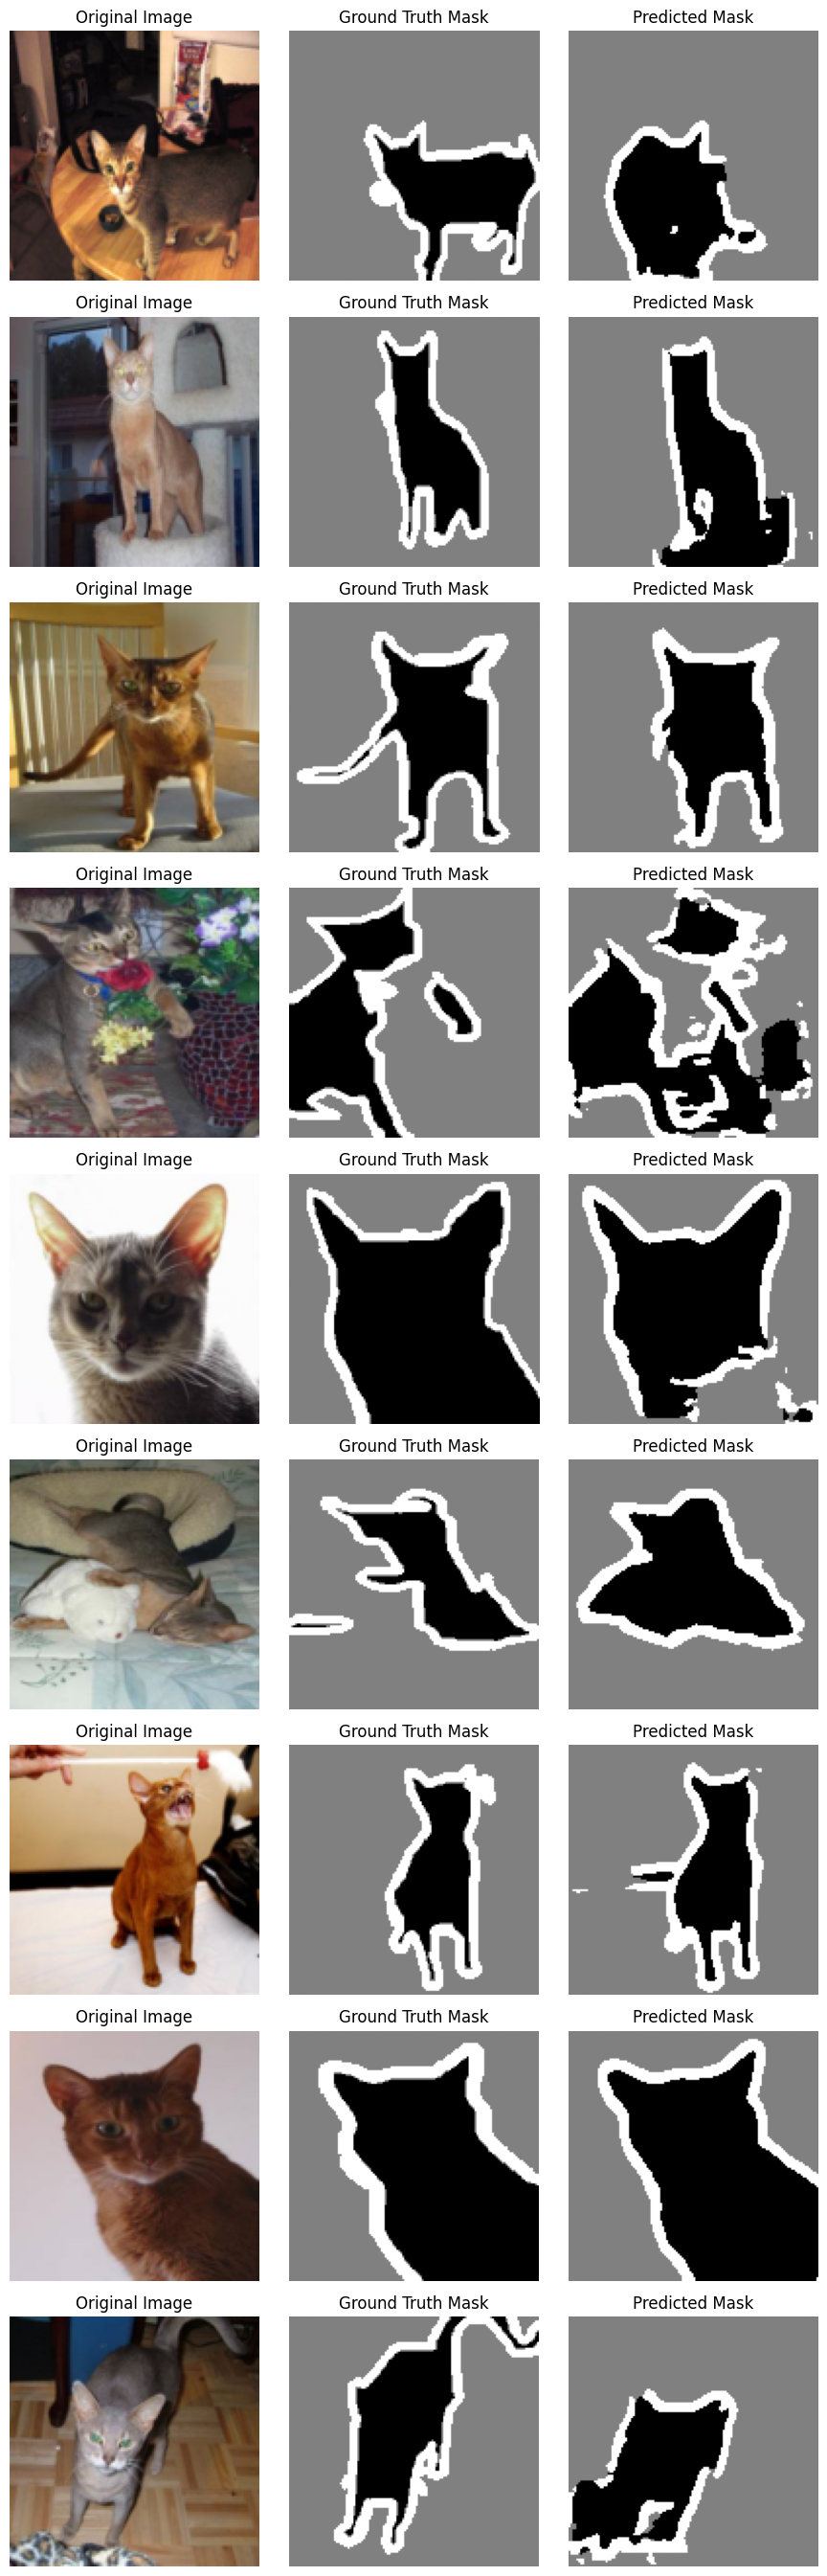

In [113]:
# Test on test set
model.eval()
images, masks = next(iter(test_loader))
images = images.to(device)
with torch.no_grad():
    predictions = model(images)
predicted_masks = torch.argmax(predictions, dim=1)
plot_predictions_grid(images, masks, predicted_masks)

## 2.4 - Save and Load Model

In [114]:
# Save model state and optimizer state after 20 epochs
epoch = 100
torch.save({
    'epoch': epoch,  # Save the current epoch number
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses,  # Save the losses (optional)
}, f'checkpoint_epoch_{epoch}.pth')

In [115]:
# Load the saved checkpoint
checkpoint = torch.load('/content/sample_data/checkpoint_epoch_100.pth')

# Restore the model and optimizer states
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Set the model to training mode again
model.train()

# Get the starting epoch
start_epoch = checkpoint['epoch']

<ipython-input-115-267c3bfaf8c9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/sample_data/checkpoint_epoch_100.pth')
